In [3]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [99]:
import seaborn as sns

In [4]:
import numpy as np

In [5]:
import scipy.io as sio

In [6]:
df = sio.loadmat('snelson1d.mat')

In [7]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [14]:
X1 = X[np.argsort(X, axis=0)]
Y1 = Y[np.argsort(X, axis=0)] 
X1 = X1.reshape(-1,1)
Y1 = Y1.reshape(-1,1)

In [15]:
M = 7

In [75]:
N_star = 200
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]

intervals = [(0.75,1.25), (2.5, 3.0), (4.25, 4.75)]

In [17]:
X_u_noisy = np.linspace(0,6, M)[:, None]

In [18]:
X_train, Y_train = X.copy(), Y.copy()
X_test, Y_test = [], [] 
test_indices = []

In [19]:
for a, b in intervals:
    indices = list(np.where(np.logical_and(X1.flatten() > a, X1.flatten() < b))[0] )
    if test_indices is None:
        test_indices = indices
    else:
        test_indices = test_indices + indices
#     print(test_indices)
# print(test_indices)
train_indices = np.arange(X.shape[0])
test_indices = np.asarray(test_indices)
train_indices = np.setdiff1d(train_indices, test_indices)
X_test, Y_test = X1[test_indices,:], Y1[test_indices]
X_train, Y_train = X1[train_indices,:], Y1[train_indices]

In [54]:
N_test = Y_test.size

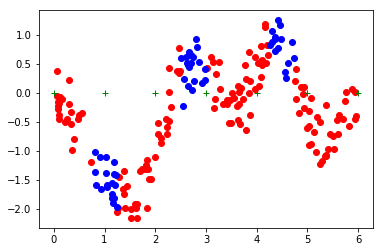

In [23]:
plt.plot(X_train, Y_train, 'ro')
plt.plot(X_test, Y_test, 'bo')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.size), 'g+')

In [24]:
def kmm_init(X, m = 20):
    """
    This is the same initialization algorithm that is used
    in Kmeans++. It's quite simple and very useful to initialize
    the locations of the inducing points in sparse GPs.
    
    http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf
    1. Take one center c1, initially chosen at random
    2. Take a new center ci with prob. \frac{D(x)^2}{\sum D(x)^2}
    3. Repeat step 2 until we have K centers.
    4. Proceed with standard K-means clustering..
    
    where D(x) is the distance to the closest cluster center. 
    If we dont want to invest time on that, just use the initialisation which is good enough atleast for the 1D case.
    
    :param X: data
    :param m: number of inducing points
    """

    # compute the distances
    XXT = np.dot(X, X.T)
    D = (-2.*XXT + np.diag(XXT)[:,np.newaxis] + np.diag(XXT)[np.newaxis,:])

    # select the first point
    s = np.random.permutation(X.shape[0])[0]
    inducing = [s]
    prob = D[s]/D[s].sum()

    for z in range(m-1):
        s = np.random.multinomial(1, prob.flatten()).argmax()
        inducing.append(s)
        prob = D[s]/D[s].sum()

    inducing = np.array(inducing)
    return X[inducing]

In [26]:
X_u = kmm_init(X_train, M)



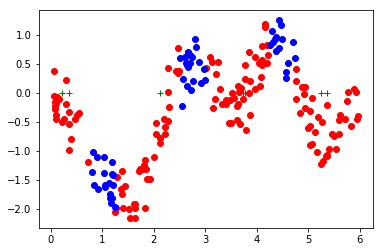

In [28]:
plt.plot(X_train, Y_train, 'ro')
plt.plot(X_test, Y_test, 'bo')
plt.plot(X_u, np.zeros(X_u.size), 'g+')

In [29]:
stan_code_var = """
data {
    int<lower=1> N;
    int<lower=1> M;
    real x[N];
    vector[N] y;
    real xu[M];

}
transformed data {
    real jitter = 1e-6;
//     real rho = 0.9;
//     real alpha = 0.85;
//     real sigma = 0.12;
}

parameters {
    real<lower=1e-6> sigma;
     real <lower=1e-6> alpha;
     real<lower=1e-6> rho;
    
    vector[M] eta;
    
}

transformed parameters{
   // matrix[M, M] R;
}
model {
    vector[N] mu;
    matrix[N, N] f_cov;
    matrix[N, N] S;
    matrix[M, N] A;
    matrix [N,N] Qff;
    matrix [N,N] L_fitc;
    matrix[N, N] K_tilde;
    matrix[N, N] K_tilde_inv;
    matrix[M, M] R;
    
    matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
    matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
    matrix[N, N] K = cov_exp_quad(x, alpha, rho);
    vector[M] Kuu_inv_u;

        
         for (m in 1:M)
             Kuu[m, m] = Kuu[m, m] + jitter;
        
        // RRT = Kuu
    R = cholesky_decompose(Kuu);
        
    {
        

                  
        //A = R^{-1}Kuf   or A = R\Kuf
        A = mdivide_left_tri_low(R, Kfu');
        
        // mu = A'v
        //  v = N(0, I)
        mu = A'*eta;
        
        // Qff = A'A
        Qff = A'*A;
        S = K - Qff;
        
        for (i in 1:N){
            for(j in 1:N){
                K_tilde[i,j] = 0.0;
                K_tilde_inv[i,j] = 0.0;
            }
            K_tilde[i,i] = S[i,i];
            K_tilde_inv[i,i] = 1./ S[i,i];
        }
        
    }
  
#     rho ~ inv_gamma(5, 5);
#     alpha ~ normal(0, 1);

// strongly informative priors, but with these the covariance matrix will be more well behaved in my experience.
// The mean of the Gaussian priors is close to the optimised MAP value of the hyperparameters.

    rho ~ normal(0.90, 0.50);
    alpha ~ normal(0.85, 0.50);
    eta ~ normal(0, 1);

    sigma ~ normal(0, 0.60);
    
    
    // exp(L1) = log(N(y_i| mu_i, sigma)*exp(-0.5*K_tilde_ii/sigma))
    // Equation 2 of Hensman, et al. Gaussian Processes for Big Data UAI 2013.
    // This is the analytical soln. of expectation of log likelihood under conditional Guassian: P(F|U).
    // K_tilde_ii = diag(Kff - Qff)[i,i]
    
    
    for(i in 1:N){
 //       target += -square((y[i] - mu[i]))/(2*square(sigma));
//        target += normal_lpdf(y[i] | mu[i], sigma);
//        target += (-0.5*K_tilde[i,i]/sigma);
        
        target += normal_lpdf(y[i] | mu[i], sigma);
        target += (-0.5*K_tilde[i,i]/sigma);

    }
    

}


"""

In [31]:
stan_model_var = pystan.StanModel(model_code=stan_code_var)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c312d50f8d5258ae7a708ce58a657c6d NOW.


In [30]:
gp_var_data = {'N':X_train.shape[0], 'x':X_train.flatten(), 'y':Y_train.flatten(), 'M':M, 'xu':X_u_noisy.flatten()}

In [32]:
print(X_train.shape)

(145, 1)


In [33]:
fit_var= stan_model_var.sampling(data=gp_var_data, iter=800, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [37]:
print(list(samples.keys()))

['sigma', 'alpha', 'rho', 'eta', 'u', 'lp__']


In [52]:
samples = fit_var.extract()
u = samples['u']
u_mean = np.mean(u, axis=0)
sigma = samples['sigma']
l = samples['rho']
sigvar = samples['alpha']
sigma_mean = np.mean(sigma, axis=0)

In [53]:
print(fit_var)

Inference for Stan model: anon_model_c312d50f8d5258ae7a708ce58a657c6d.
2 chains, each with iter=800; warmup=400; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=800.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma    0.43  9.5e-4   0.03   0.38   0.41   0.43   0.45   0.48    800    1.0
alpha    0.93    0.01   0.24   0.55   0.76   0.89   1.08   1.46    511    1.0
rho      0.94  3.8e-3    0.1   0.77   0.87   0.93    1.0   1.15    676    1.0
eta[0]   0.26  5.2e-3   0.15  -0.03   0.16   0.26   0.35   0.54    800    1.0
eta[1]  -2.68    0.03   0.58  -4.01  -3.03  -2.64  -2.25   -1.7    529    1.0
eta[2]   0.77    0.01   0.37   0.09    0.5   0.75   0.99   1.55    674    1.0
eta[3]  -0.19  9.7e-3   0.26  -0.72  -0.37  -0.19-7.0e-3   0.35    736    1.0
eta[4]   0.36  9.4e-3   0.24  -0.09    0.2   0.35   0.52   0.86    661    1.0
eta[5]  -0.81  9.7e-3   0.25   -1.4  -0.96  -0.79  -0.63  -0.39    673    1.0
eta[6]  -0.15    0.01   0.38  -0.89

In [38]:
# mu = samples['mu']
print(list(samples.keys()))
# sigma_mean = np.mean(mu, axis=0)

['sigma', 'alpha', 'rho', 'eta', 'u', 'lp__']


In [39]:
sigma_samples = samples['sigma']
alpha_samples = samples['alpha']
rho_samples = samples['rho']

In [40]:
sigma_mean = np.mean(samples['sigma'])
sigma_median = np.nanmedian(samples['sigma'])

l_mean = np.mean(samples['rho'])
l_median = np.nanmedian(samples['rho'])

sigvar_mean = np.mean(samples['alpha'])
sigvar_median = np.nanmedian(samples['alpha'])

print("mean of noise variance: %.2f" % sigma_mean)
print("median of noise variance: %.2f"% sigma_median)
print("mean of lengthscale: %.3f"% l_mean)
print("median of lengthscale: %.3f"% l_median)
print("mean of signal variance: %.3f"% sigvar_mean)
print("median of signal variance: %.3f"% sigvar_median)

mean of noise variance: 0.43
median of noise variance: 0.43
mean of lengthscale: 0.940
median of lengthscale: 0.930
mean of signal variance: 0.935
median of signal variance: 0.894


In [41]:
eta = samples['eta']

In [42]:
print(eta.shape)

(800, 7)


In [43]:
eta_mean = np.nanmean(samples['eta'], axis=0)
eta_median = np.nanmedian(samples['eta'], axis=0)

In [44]:
eta_perc_25 = np.percentile(eta, 2.5, axis=0)
eta_perc_975 = np.percentile(eta, 97.5, axis=0)

In [48]:
eta_mean = np.mean(eta, axis=0)

#### Plotting posterior distribution of v.

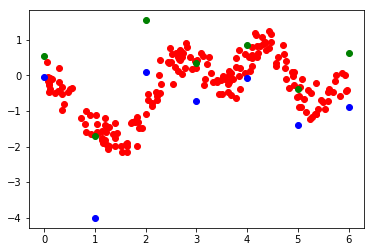

In [46]:
plt.plot(X,Y, 'ro')
plt.plot(X_u_noisy, eta_perc_25, 'bo')
plt.plot(X_u_noisy, eta_perc_975, 'go')
# plt.plot(X_u_noisy, eta_mean, 'ko')
# plt.plot(X_u_noisy, eta_mean, 'yo')
# plt.plot(X, f[320,:], 'go')

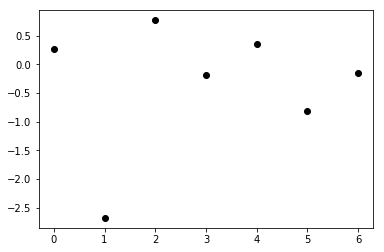

In [49]:
plt.plot(X_u_noisy, eta_mean, 'ko')

In [50]:
u_perc_25 = np.percentile(u, 2.5, axis=0)
u_perc_975 = np.percentile(u, 97.5, axis=0)

In [29]:

class ProcessStanSamples(object):
    
    def _params_samples(samples):
        keys = list(samples.keys())
        return keys
    
    def plot_histograms(samples):
        sigma_samples = samples['sigma']
        rho_samples = samples['rho']
        alpha_samples = samples['alpha']
        if 'f' in self._params_samples(samples):
            f_samples = samples['f']
        
        if 'u' in self._params_samples(samples):
            u_samples = samples['u']
        
        
        f, axs = plt.subplots(2,2, sharey=True)
        axs[0,0].hist(sigma_samples)
        axs[0,0].set_title('Plotting samples for sigma')
        axs[0,0].legend(['Noise variance'])
        axs[0,1].hist(rho_samples)
        axs[0,1].set_title('Plotting samples for lengthscale')
        axs[0,1].legend(['lengthscale'])
        axs[1,0].hist(alpha_samples)
#         axs[1,0].set_title('Plotting samples for signalvariance')
        axs[1,0].legend(['signal var'])
        
    

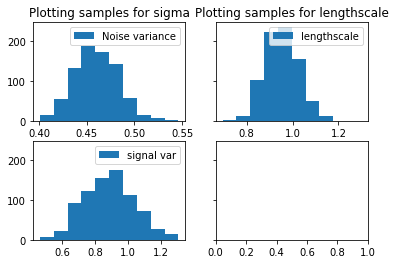

In [30]:
f, axs = plt.subplots(2,2, sharey=True)
axs[0,0].hist(sigma_samples)
axs[0,0].set_title('Plotting samples for sigma')
axs[0,0].legend(['Noise variance'])
axs[0,1].hist(rho_samples)
axs[0,1].set_title('Plotting samples for lengthscale')
axs[0,1].legend(['lengthscale'])
axs[1,0].hist(alpha_samples)
# axs[1,0].set_title('Plotting samples for signalvariance')
axs[1,0].legend(['signal var'])

In [60]:
eta_samples = samples['eta']

In [76]:
N_star = 200
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]

In [77]:
print(alpha_samples.shape)

(800,)


In [78]:
def kernel_rbf(alpha, rho, Xi, Xj=None):
    if Xj is None:
        Xj = Xi
    
    N1,D1 = Xi.shape[0],1
    N2,D2 = Xj.shape[0],1
    
    diff = Xi.reshape(N1,1,D1) - Xj.reshape(1,N2,D2)
    K = (alpha**2)*np.exp(-0.5*np.sum(np.square(diff),-1)/(rho)**2)
    return K
    

In [79]:
Kuu = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_u_noisy)

In [80]:
K_star_u = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_star, Xj=X_u_noisy)

In [81]:
alpha_sub_samples = alpha_samples[::40]
rho_sub_samples = rho_samples[::40]
sigma_sub_samples = sigma_samples[::40]
eta_sub_samples = eta_samples[::40,:]

In [82]:
print(alpha_sub_samples.shape)
N_s = 10

(20,)


####  Utility function to generate predictive distribution:

$p(f^*|y) = \int \int p(f^*|u) q(u, \theta) du d\theta$

We will obtain the above expression using MCMC samples. The stan code above samples from the optimal variational distribution $q(u,\theta)$

In [122]:
# function to generate mean and covariance matrics ..

def generate_preds(alpha, rho, v, Xi, Xj):
    Kuu = kernel_rbf(alpha, rho, Xj)
    K_star_u = kernel_rbf(alpha, rho, Xi, Xj)
    K_star_star = kernel_rbf(alpha, rho, Xi)
    
    R = np.linalg.cholesky(Kuu)
    A = np.linalg.solve(R, np.transpose(K_star_u))
#     print(A.shape)
    A_T = np.transpose(A)
    f_star_mean = np.dot(A_T, v)
    Q_star_star = np.dot(A_T, A)
    
    S = K_star_star - Q_star_star
    return f_star_mean, S



In [123]:
N_samples = 800

In [124]:
print(N_star)

200


In [125]:
f_sum = np.zeros(N_star)
f_sum2 = np.zeros(N_star)
S_sum = np.zeros((N_star,N_star))
S_diag = np.zeros(N_star)
for i in range(N_samples):
    f_star_mean, S = generate_preds(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:],  Xi=X_star, Xj=X_u_noisy)
    f_sum = f_sum + f_star_mean
    f_sum2 = f_sum2 + f_star_mean**2
    S_sum = S_sum + S
    S_diag = np.diag(S)

In [126]:
cov_fin = S_diag/N_samples + f_sum2/N_samples - (f_sum/N_samples)**2

In [127]:
f_fin = f_sum / N_samples
S_sum = S_sum / N_samples

In [90]:
# print(f_fin)

In [92]:
# print(cov_fin)

####   Plot for predictive distribution for Snelson dataset using samples obtained from optimal variational distribution : q(v, $\theta$)

In [43]:
f_fin = f_sum / N_s
S_sum = S_sum / N_s

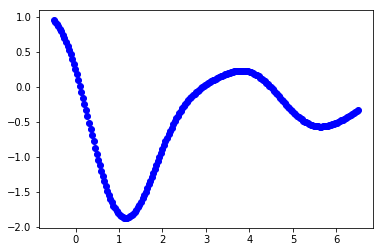

In [128]:
plt.plot(X_star, f_fin, 'bo')

In [129]:
a = np.random.multivariate_normal(f_fin, S_sum, 6)
a2 = np.random.multivariate_normal(f_fin, np.diag(cov_fin), 8)

In [94]:
print(a.shape)

(6, 200)


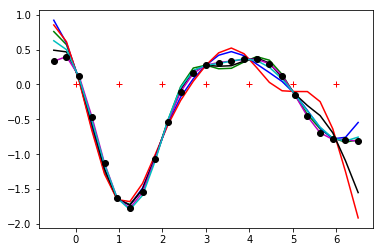

In [58]:
plt.plot(X_star, a[0], 'g-')
plt.plot(X_star, a[1], 'b-')
plt.plot(X_star, a[2], 'r-')
plt.plot(X_star, a[3], 'k-')
plt.plot(X_star, a[4], 'm-')
plt.plot(X_star, a[5], 'c-')
plt.plot(X_star, a[4], 'ko')
# plt.plot(X, Y, 'mo')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')

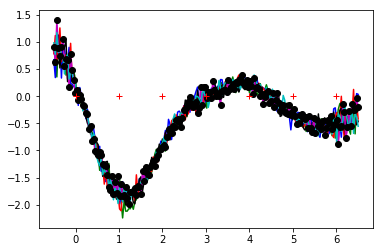

In [130]:
plt.plot(X_star, a2[0], 'g-')
plt.plot(X_star, a2[1], 'b-')
plt.plot(X_star, a2[2], 'r-')
plt.plot(X_star, a2[3], 'k-')
plt.plot(X_star, a2[4], 'm-')
plt.plot(X_star, a2[5], 'c-')
plt.plot(X_star, a2[4], 'ko')
# plt.plot(X, Y, 'mo')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')

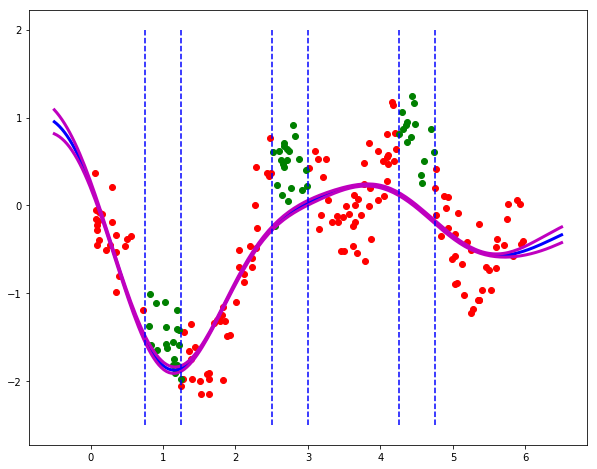

In [131]:
fig, ax = plt.subplots(1,1 , figsize=(10,8))
ax.plot(X_train, Y_train, 'ro')
ax.plot(X_test, Y_test, 'go')
ax.plot(X_star, f_fin, 'b-', lw=3)
ax.plot(X_star, f_fin + 2*cov_fin, 'm-', lw=3)
ax.plot(X_star, f_fin - 2*cov_fin, 'm-', lw=3)
for i in intervals:
    ax.plot([i[0], i[0]], [-2.5, 2], 'b--')
    ax.plot([i[1], i[1]], [-2.5, 2], 'b--')

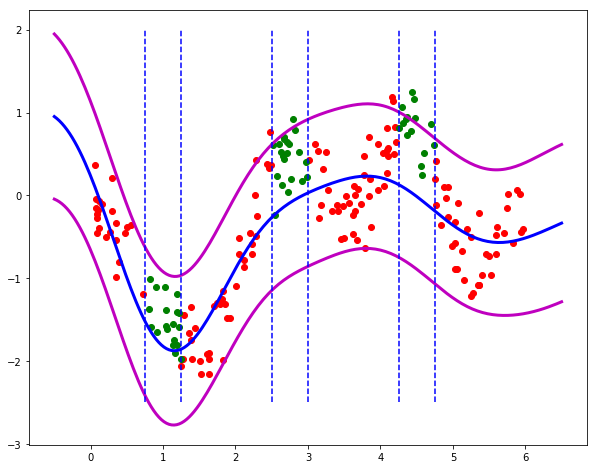

In [113]:
fig, ax = plt.subplots(1,1 , figsize=(10,8))
ax.plot(X_train, Y_train, 'ro')
ax.plot(X_test, Y_test, 'go')
ax.plot(X_star, f_fin, 'b-', lw=3)
plt.plot(X_star, f_fin + 2*cov_fin + 2*np.mean(sigma_samples, axis=0), 'm-', lw=3)
plt.plot(X_star, f_fin - 2*cov_fin -2*np.mean(sigma_samples, axis=0), 'm-', lw=3)
for i in intervals:
    ax.plot([i[0], i[0]], [-2.5, 2], 'b--')
    ax.plot([i[1], i[1]], [-2.5, 2], 'b--')

#### Predictive densities for test points

In [132]:
f_sum = np.zeros(N_test)
f_sum2 = np.zeros(N_test)
S_sum = np.zeros((N_test,N_test))
S_diag = np.zeros(N_test)
for i in range(N_samples):
    f_star_mean, S = generate_preds(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:],  Xi=X_test, Xj=X_u_noisy)
    f_sum = f_sum + f_star_mean
    f_sum2 = f_sum2 + f_star_mean**2
    S_sum = S_sum + S
    S_diag = np.diag(S)


In [135]:
cov_fin = S_diag/N_samples + f_sum2/N_samples - (f_sum/N_samples)**2
f_fin = f_sum / N_samples

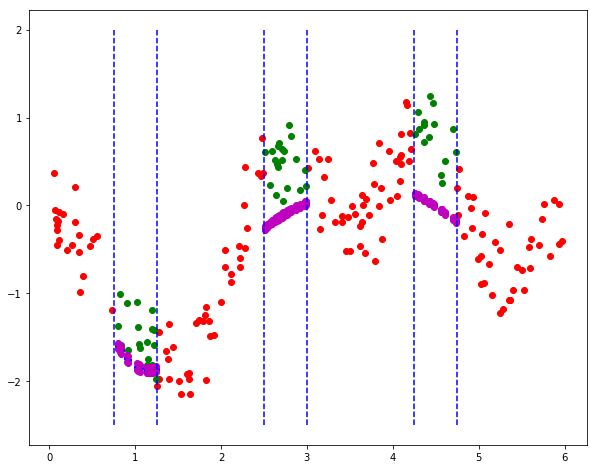

In [145]:
fig, ax = plt.subplots(1,1 , figsize=(10,8))
ax.plot(X_train, Y_train, 'ro')
ax.plot(X_test, Y_test, 'go')
ax.plot(X_test, f_fin, 'bo')
plt.plot(X_test, f_fin + 2*cov_fin , 'mo')
plt.plot(X_test, f_fin - 2*cov_fin , 'mo')
for i in intervals:
    ax.plot([i[0], i[0]], [-2.5, 2], 'b--')
    ax.plot([i[1], i[1]], [-2.5, 2], 'b--')

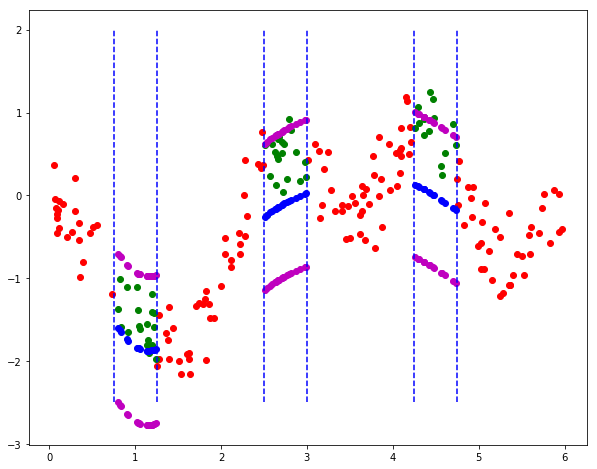

In [147]:
fig, ax = plt.subplots(1,1 , figsize=(10,8))
ax.plot(X_train, Y_train, 'ro')
ax.plot(X_test, Y_test, 'go')
ax.plot(X_test, f_fin, 'bo')
plt.plot(X_test, f_fin + 2*cov_fin + 2*np.mean(sigma_samples, axis=0), 'mo')
plt.plot(X_test, f_fin - 2*cov_fin -2*np.mean(sigma_samples, axis=0), 'mo')
for i in intervals:
    ax.plot([i[0], i[0]], [-2.5, 2], 'b--')
    ax.plot([i[1], i[1]], [-2.5, 2], 'b--')

In [148]:
def RMSE(Y_star, Y_test):
    rmse = np.sqrt(np.mean(np.square(Y_star - Y_test)))
    return rmse

def NMSE(Y_star, Y_test):
    nmse = np.mean(np.square(Y_star - Y_test)) / np.mean(np.square(Y_test - np.mean(Y_test)))
    return nmse

def MLPPD(Y_star, Y_test, var_star):
    mlppd = 0.5* (np.sum(np.square(Y_star - Y_test)/var_star + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd

def MLPPD2(Y_star, Y_test, var_star):
    mlppd2 = 0.5* (np.sum(np.square(Y_star - Y_test)/(var_star*np.abs(Y_test)) + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd2


####  RMSE, NMSE and MLPPD values for Snelson test set.

In [151]:
RMSE_test = RMSE(f_fin, Y_test)
NMSE_test = NMSE(f_fin, Y_test)
MLPPD_test1 = MLPPD(f_fin, Y_test, cov_fin)
# MLPPD_test2 = MLPPD(y_star_mean, Y_test, y_star_var)
MLPPD_test2 = MLPPD2(f_fin, Y_test, cov_fin+np.mean(sigma_samples, axis=0))
print("RMSE error: %.3f"%RMSE_test)
print("NMSE error: %.3f"%NMSE_test)

print("MLPPD error: %.3f"%MLPPD_test1)
print("MLPPD2 error: %.3f"%MLPPD_test2)


RMSE error: 1.443
NMSE error: 1.896
MLPPD error: 3901.357
MLPPD2 error: 253.064


#####  Generate plot for u 

In [60]:
def generate_u(alpha, rho, v, Xi):
    Kuu = kernel_rbf(alpha, rho, Xi=Xi)
    R = np.linalg.cholesky(Kuu)

    u_mean = np.dot(R, v)
    return u_mean

In [62]:
print(M)

20


In [69]:
u_sum = np.zeros(M)
# S_sum = np.zeros((N,N))
for i in range(N_samples):
    u_mean = generate_u(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:], Xi = X_u_noisy)
    u_sum = u_sum + u_mean

In [70]:
u_fin = u_sum / N_samples

Plot of inducing inputs and inducing outputs(u)

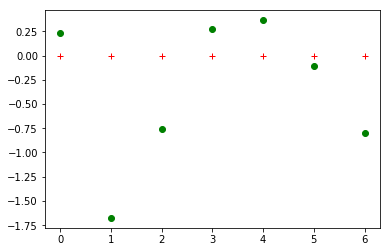

In [71]:
plt.plot(X_u_noisy, u_fin, 'go')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')